# 手写数字识别

In [1]:
import copy
import math
import time
import random
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.nn.functional as F
from torchvision import datasets

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


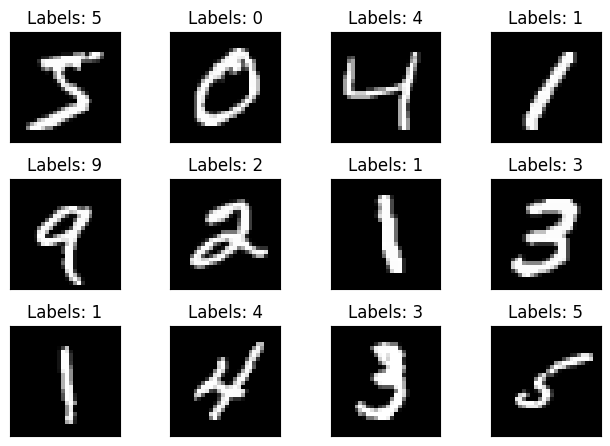

In [4]:
# 展示数据集
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = LeNet().to(device=device)

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    inputs = inputs.to(device)
    targets = targets.to(device)
    # print(inputs.shape)
    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs).cpu()
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer 
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    inputs = inputs.to(device)
    targets = targets.to(device)
  
    # Inference
    outputs = model(inputs).cpu()

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [8]:
lr = 0.01
momentum = 0.5
num_epoch = 5

optimizer = torch.optim.SGD(model.parameters(),  lr=lr, momentum=momentum)  # lr学习率，momentum冲量
criterion = nn.CrossEntropyLoss()  # 交叉熵损失


best_accuracy = 0
best_checkpoint = dict()
gradients = dict()
for epoch in range(num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = evaluate(model, test_loader)
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
        
        # 将每个梯度保存到字典中
        for name, parameter in model.named_parameters():
            if parameter.grad is not None:
                # .clone()确保我们有梯度的复制，而非引用
                gradients[name] = parameter.grad.clone()

    print(f'Epoch{epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')


torch.save(best_checkpoint['state_dict'], './model.pt')
torch.save(gradients, './model_gradients.pt')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])

train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 Accuracy 93.99% / Best Accuracy: 93.99%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 Accuracy 97.38% / Best Accuracy: 97.38%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 Accuracy 98.03% / Best Accuracy: 98.03%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 Accuracy 97.71% / Best Accuracy: 98.03%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 Accuracy 97.67% / Best Accuracy: 98.03%
=> loading best checkpoint


<All keys matched successfully>

In [9]:
model_accuracy = evaluate(model, test_loader)
print(f"Model has accuracy={model_accuracy:.2f}%")

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Model has accuracy=98.03%


## 预测单张图片

In [10]:
from torchvision import transforms
from PIL import Image
# Load the saved model
model = LeNet()  # Replace MyModel with your model's class
model.load_state_dict(torch.load('./model.pt'))
model.eval()  # Set the model to evaluation mode

# Preprocess the image (assuming input is grayscale 28x28 as in MNIST)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
        transforms.Resize((28, 28)),  # Resize to match MNIST dimensions
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize as per model's training
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Perform prediction on a single image
def predict_image(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1, keepdim=True)  # Get the predicted class
    return prediction.item()

# Example usage
image_path = 'test.png'  # Replace with the actual image path
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')

Predicted label: 3


/tmp/ipykernel_3595/2116040951.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model.pt'))


## 预测多张图片

In [11]:
def show_images(images, labels, preds, num_rows=4, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()  # Flatten axes array for easy iteration
    for idx in range(num_rows * num_cols):
        if idx >= len(images):
            break
        ax = axes[idx]
        img = images[idx].cpu().numpy().squeeze()  # Convert tensor to numpy and remove unnecessary dimensions
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {labels[idx].item()}\nPred: {preds[idx].item()}')
        ax.axis('off')  # Turn off axis labels
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3595/2253264289.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model.pt'))


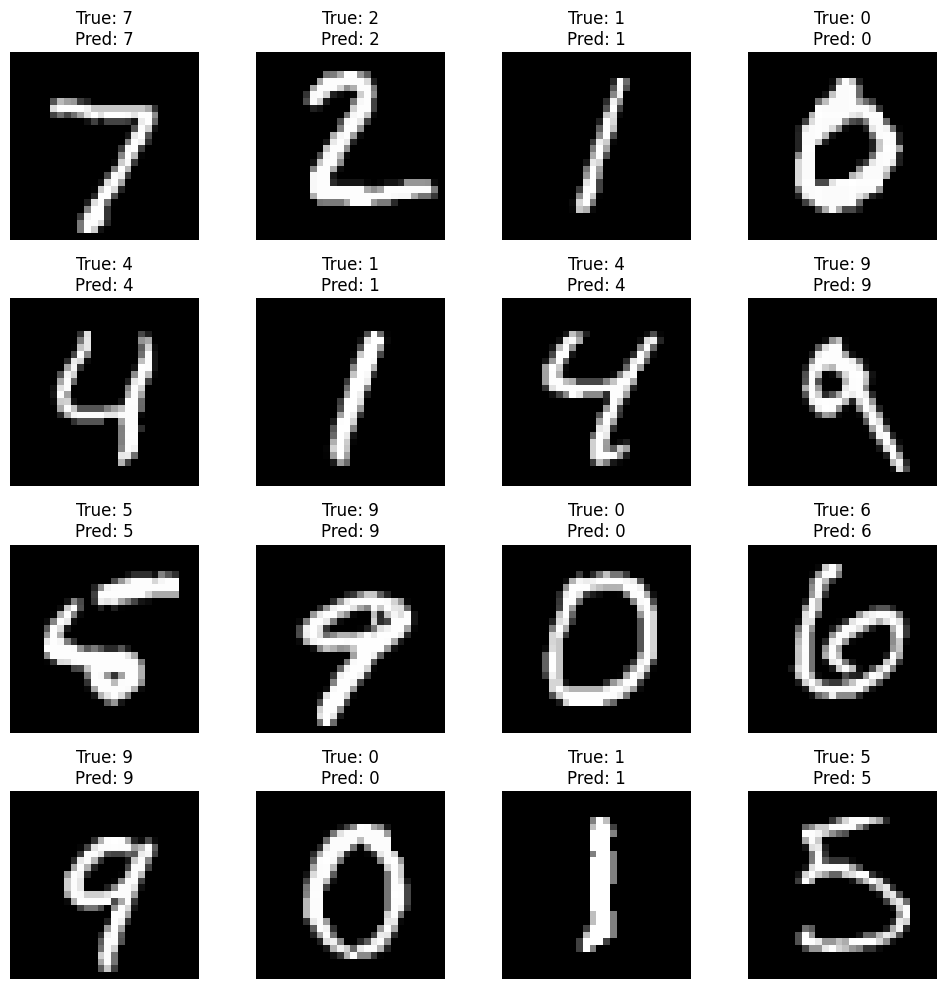

In [12]:
# Load the saved model
model = LeNet()  # Replace MyModel with your model's class
model.load_state_dict(torch.load('./model.pt'))
model.eval()  # Set the model to evaluation mode
# Get a batch of test data
test_iter = iter(test_loader)
images, labels = next(test_iter)

# Run the model to predict labels
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Get the predicted labels

# Show images with true and predicted labels
show_images(images.cpu(), labels.cpu(), preds.cpu())